<a href="https://colab.research.google.com/github/islams1/Islam_Sherif/blob/main1/Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets


In [ ]:
#upgrade transformers
!pip install --upgrade transformers


In [ ]:
!pip install emoji

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji
from collections import Counter
import string

# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq /content/sentiment140.zip -d /content/sentiment

replace /content/sentiment/training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
# Load the Sentiment140 dataset
file_path = '/content/sentiment/training.1600000.processed.noemoticon.csv'  # Update with the actual path of your dataset
columns = ['target', 'id', 'date', 'flag', 'user', 'text']  # Column names as per the dataset description
df = pd.read_csv(file_path, encoding='ISO-8859-1', header=None, names=columns)

In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Get the number of rows and columns in the dataset
print(f"Dataset shape: {df.shape}")

Dataset shape: (1600000, 6)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.duplicated().sum()

0

In [ ]:
# Convert target to more readable format (0 = Negative, 4 = Positive)
df['sentiment'] = df['target'].map({0: 'Negative', 4: 'Positive'})

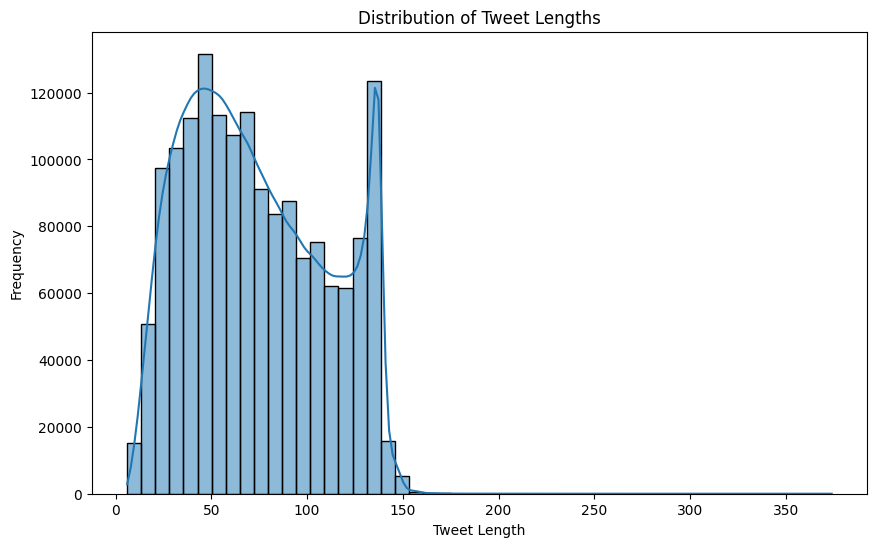

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df['text_length'] = df['text'].apply(len)
# Plot the distribution of tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()




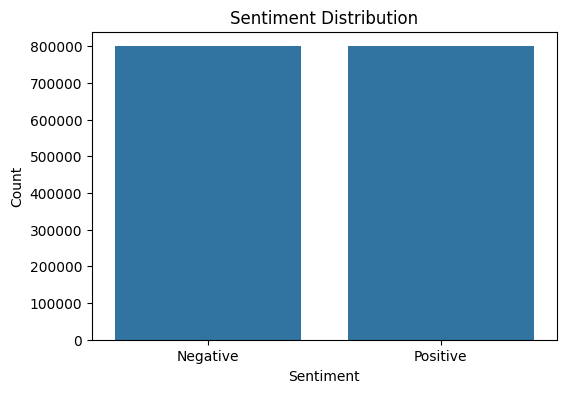

In [ ]:
# Visualize the sentiment label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


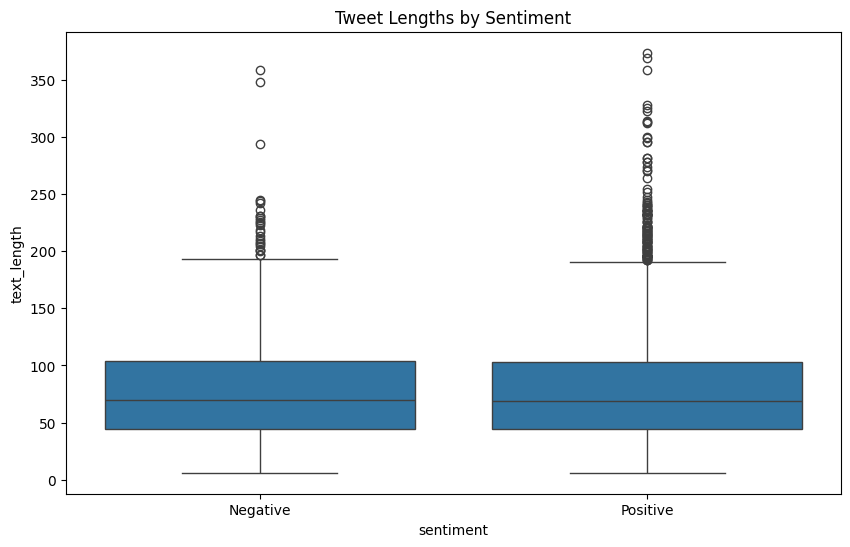


Tweet Length Statistics:
              count       mean        std  min   25%   50%    75%    max
sentiment                                                               
Negative   800000.0  74.301790  36.743260  6.0  44.0  70.0  104.0  359.0
Positive   800000.0  73.878433  36.135274  6.0  44.0  69.0  103.0  374.0


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='text_length', data=df)
plt.title('Tweet Lengths by Sentiment')
plt.show()

print("\nTweet Length Statistics:")
print(df.groupby('sentiment')['text_length'].describe())

<ipython-input-30-435600cbd2b0>:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


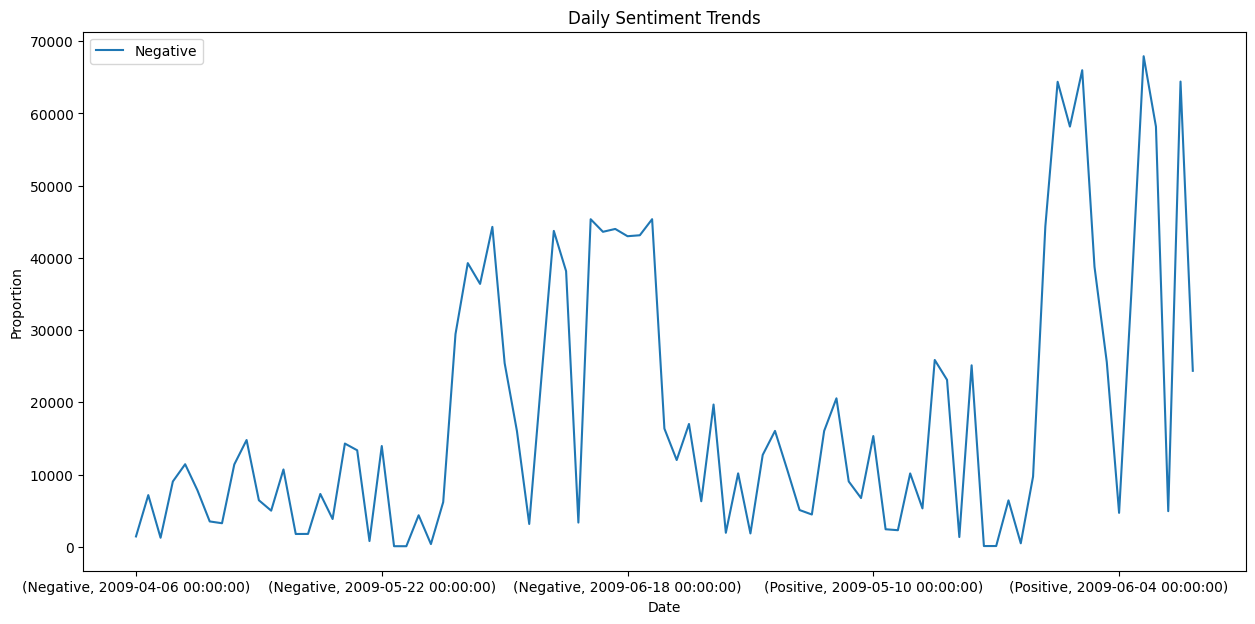

In [ ]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['date'])

# Set date as index
df.set_index('date', inplace=True)

# Resample by day and calculate sentiment proportions
daily_sentiment = df.groupby([pd.Grouper(freq='D'), 'sentiment'])['sentiment'].count().unstack()

# Plot sentiment trends over time
plt.figure(figsize=(15,7))
daily_sentiment.unstack().plot(ax=plt.gca())
plt.title('Daily Sentiment Trends')
plt.xlabel('Date')
plt.ylabel('Proportion')
plt.legend(['Negative', 'Positive'])
plt.show()


In [ ]:
data=df[['text','target']]
data.head()


,text,target
date,,
2009-04-06 22:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
2009-04-06 22:19:49,is upset that he can't update his Facebook by ...,0
2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...,0
2009-04-06 22:19:57,my whole body feels itchy and like its on fire,0
2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all....",0


In [ ]:
data['target'] = data['target'].replace(4,1)
data['target'].value_counts()

<ipython-input-32-3125ce2907dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


,count
target,
0,800000
1,800000


In [ ]:
data_pos = data[data['target'] == 1]
data_pos.head()

,text,target
date,,
2009-04-06 22:22:45,I LOVE @Health4UandPets u guys r the best!!,1
2009-04-06 22:22:45,im meeting up with one of my besties tonight! ...,1
2009-04-06 22:22:46,"@DaRealSunisaKim Thanks for the Twitter add, S...",1
2009-04-06 22:22:46,Being sick can be really cheap when it hurts t...,1
2009-04-06 22:22:46,@LovesBrooklyn2 he has that effect on everyone,1


In [ ]:
data_neg = data[data['target'] == 0]
data_neg.head()

,text,target
date,,
2009-04-06 22:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
2009-04-06 22:19:49,is upset that he can't update his Facebook by ...,0
2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...,0
2009-04-06 22:19:57,my whole body feels itchy and like its on fire,0
2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all....",0


In [ ]:
import numpy as np
data_pos = data_pos.sample(100000)
data_neg = data_neg.sample(100000)
dataset = pd.concat([data_pos, data_neg])
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset=dataset.reset_index(drop=True)
dataset.head()

,text,target
0,Sending off yet another care package to Iraq. ...,1
1,They've gone,1
2,@rev_chas I think there are actually outlets o...,0
3,well crap he got crashed out! that sicks!,0
4,@MNewYork I didn't get one why am I actually ...,0


In [ ]:
X=list(dataset['text'])
X[:5]

["Sending off yet another care package to Iraq.  Won't have to do this anymore sooooooooon!  ",
 "They've gone ",
 "@rev_chas I think there are actually outlets on the bus, but I didn't bring a charger with me ",
 'well crap he got crashed out! that sicks! ',
 "@MNewYork I didn't get one  why am I actually excited for this drake game smh @me"]

In [ ]:
y=list(dataset['target'])
y[:5]

[1, 1, 0, 0, 0]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42,)
X_train[:5]

['Off to the cabin for the rest of the weekend  boring',
 '@oliviamunn ah..i have to wait til tomorrow over here in the bricks ',
 'Oh I hope tomorrow goes well... ',
 'Spending some time with this little guy.  (picture is not from today) http://twitpic.com/6ulyf',
 '@JonathanRKnight  Realistic is no fun if we have to turn back into boring old ladies w/ out you guys around!!   LOL']

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)


In [ ]:
y_train[:5]


[0, 0, 0, 1, 0]

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:
from transformers import TFDistilBertForSequenceClassification, Trainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.1,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
)

In [ ]:
!pip install datasets

In [ ]:
import tensorflow as tf
from datasets import Dataset
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Convert TensorFlow datasets to Hugging Face Datasets
# Use Dataset.from_dict with correct format.  The keys should correspond to the column names and the values are lists of the column values.
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "label": y_train
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "label": y_test
})

# Ensure you are using the PyTorch version of the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# Use the TrainingArguments class for PyTorch
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.1,
    logging_dir='./logs',
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,0.661900
200,0.493600


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,trainer.predict(test_dataset)[1]))

Step,Training Loss
100,0.661900
200,0.493600


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20068
           1       1.00      1.00      1.00     19932

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



In [ ]:
!pip install streamlit
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
import streamlit as st
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import tensorflow as tf

# Function to load the model and tokenizer
def load_model_and_tokenizer():
    """Loads the DistilBERT model and tokenizer"""
    model_name = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
    model = TFDistilBertForSequenceClassification.from_pretrained(model_name)
    return model, tokenizer

# Load the model and tokenizer
model, tokenizer = load_model_and_tokenizer()

# Streamlit interface for user inputs
st.title('Text Classification with DistilBERT')

# Text input from the user
user_input = st.text_area("Enter the text to classify")

if user_input:
    # Tokenize the input
    inputs = tokenizer(user_input, return_tensors="tf", truncation=True, padding=True)

    # Make predictions
    outputs = model(inputs)
    predictions = tf.argmax(outputs.logits, axis=-1)

    # Display prediction results
    st.write(f"Predicted class: {predictions.numpy()[0]}")

# Function to prepare training and testing datasets
def prepare_data(train_encodings, test_encodings, y_train, y_test):
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train
    ))

    test_dataset = tf.data.Dataset.from_tensor_slices((
        dict(test_encodings),
        y_test
    ))

    return train_dataset, test_dataset

# Example of training the model
def train_model(train_dataset, test_dataset):
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.metrics.SparseCategoricalAccuracy()]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Train the model
    model.fit(train_dataset.batch(16), validation_data=test_dataset.batch(16), epochs=3)

# Example: Training the model (you would need the actual encodings and labels for this)
# train_encodings, test_encodings, y_train, y_test = ...
# train_dataset, test_dataset = prepare_data(train_encodings, test_encodings, y_train, y_test)
# train_model(train_dataset, test_dataset)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that y

In [ ]:
#local tunnel
!npm install localtunnel
!pip install streamlit-drawable-canvas




up to date, audited 23 packages in 671ms

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
#password local tunnel
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))



Password/Enpoint IP for localtunnel is: 34.143.231.225


In [ ]:
!streamlit run zoz.py &>/content/logs.txt &
!npx localtunnel --port 8501

your url is: https://beige-wombats-deny.loca.lt
^C


In [ ]:
%%writefile zoz.py
import streamlit as st
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import tensorflow as tf
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the Sentiment140 dataset
file_path = '/content/sentiment/training.1600000.processed.noemoticon.csv'  # Update with the actual path of your dataset
columns = ['target', 'id', 'date', 'flag', 'user', 'text']  # Column names as per the dataset description
df = pd.read_csv(file_path, encoding='ISO-8859-1', header=None, names=columns)

def load_model_and_tokenizer():
    """Loads the DistilBERT model and tokenizer."""
    model_name = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
    model = TFDistilBertForSequenceClassification.from_pretrained(model_name)
    return model, tokenizer

# Load the model and tokenizer
model, tokenizer = load_model_and_tokenizer()

def predict_sentiment(text, model, tokenizer):
    """Predicts the sentiment of the given text."""
    inputs = tokenizer(text, return_tensors="tf")
    outputs = model(**inputs)
    predicted_class = tf.math.argmax(outputs.logits, axis=-1).numpy()[0]
    sentiment_labels = ["Positive", "Negative"]  # Replace with your actual labels
    return sentiment_labels[predicted_class]

st.title("Tweet Sentiment Analyzer")

# Input text area
text_input = st.text_area("Enter a tweet:")

if st.button("Analyze"):
    sentiment = predict_sentiment(text_input, model, tokenizer)  # Pass model as an argument
    st.write(f"Sentiment: {sentiment}")

    # ... (previous code for data loading, preprocessing, modeling)

# EDA and Visualization Section in Streamlit
st.subheader("Exploratory Data Analysis")
df['sentiment'] = df['target'].map({0: 'Negative', 4: 'Positive'})
# 1. Sentiment Distribution
st.write("Sentiment Distribution:")
fig_sentiment_dist, ax_sentiment_dist = plt.subplots()
sns.countplot(x='sentiment', data=df, ax=ax_sentiment_dist)
ax_sentiment_dist.set_title('Sentiment Distribution')
st.pyplot(fig_sentiment_dist)

# 2. Tweet Length Distribution
st.write("Tweet Length Distribution:")
df['text_length'] = df['text'].apply(len)

fig_length_dist, ax_length_dist = plt.subplots()
sns.histplot(df['text_length'], bins=50, kde=True, ax=ax_length_dist)
ax_length_dist.set_title('Distribution of Tweet Lengths')
st.pyplot(fig_length_dist)

# 3. Tweet Length by Sentiment
st.write("Tweet Lengths by Sentiment:")
fig_length_sentiment, ax_length_sentiment = plt.subplots()
sns.boxplot(x='sentiment', y='text_length', data=df, ax=ax_length_sentiment)
ax_length_sentiment.set_title('Tweet Lengths by Sentiment')
st.pyplot(fig_length_sentiment)

# 4. Daily Sentiment Trends
st.write("Daily Sentiment Trends:")
if st.checkbox("Show Daily Trends"): # Use a checkbox for user control on computationally intensive plots
    # Convert 'date' to datetime (handles parsing errors)
    try:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date'])
        df.set_index('date', inplace=True)
        daily_sentiment = df.groupby([pd.Grouper(freq='D'), 'sentiment'])['sentiment'].count().unstack()

        fig_daily, ax_daily = plt.subplots(figsize=(15, 7))
        daily_sentiment.unstack().plot(ax=ax_daily)  # Use the axes for Streamlit
        ax_daily.set_title('Daily Sentiment Trends')
        ax_daily.set_xlabel('Date')
        ax_daily.set_ylabel('Proportion')
        ax_daily.legend(['Negative', 'Positive'])
        st.pyplot(fig_daily)

    except Exception as e:
        st.error(f"An error occurred during date processing: {e}")
        # Handle potential errors (e.g., if 'date' column has inconsistent format)

# ... rest of the Streamlit app code

Overwriting zoz.py
